In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_20612/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


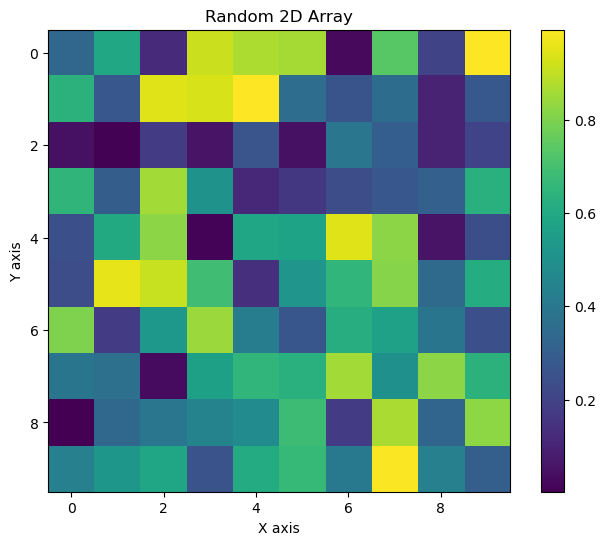

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                 
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap

                    drop_rate = 0.5, 

                    exclude_class = True, # True # False # gesture에서 10번째 클래스 제외
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration,
            exclude_class)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on,
                        drop_rate).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    tr_acc_best = 0
    val_acc_best = 0
    val_acc_now = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    no_tr_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (e_transport_swap > 0 or e_transport_swap_tr > 0):
            assert not (e_transport_swap > 0 and e_transport_swap_tr > 0)
            if e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap:
                net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                no_val_best_growth_count = 0
            if e_transport_swap_tr > 0 and no_tr_best_growth_count == e_transport_swap_tr:
                net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                no_tr_best_growth_count = 0

        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################
                        
            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            val_loss=0
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += val_loss_temp.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1

                if tr_acc_best < tr_acc:
                    tr_acc_best = tr_acc
                    no_tr_best_growth_count = 0
                else:
                    no_tr_best_growth_count = no_tr_best_growth_count + 1
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter/val_loss:{loss:.3f}/{val_loss:.3f}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc_best:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
### my_snn control board ########################
decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
const2 = False # trace 할거면 True, 안할거면 False

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

if const2 == True:
    const2 = decay
else:
    const2 = 0.0

wandb.init(project= f'my_snn {unique_name}',save_code=True)

my_snn_system(  devices = "4",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 16, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_GESTURE_TONIC',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',512],
                cfg = ['M','M','M',200,200],
                # cfg = [200,200],
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = 0.001, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'hard_sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = 5, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = 100_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = True, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
                e_transport_swap = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_tr = 5, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                
                drop_rate = 0.0,

                exclude_class = True, # True # False # gesture에서 10번째 클래스 제외
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# DDP 실행 코드
'''
ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
'''


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin



your OTTT_sWS_on False 

processing - exclude 'other' class
processing done - exclude 'other' class

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): DimChanger_for_FC_sstep()
      (4): SYNAPSE_FC_trace_sstep()
      (5): LIF_layer_trace_sstep()
      (6): Feedback_Receiver()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): Feedback_Receiver()
      (10): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 144,810, system's param_num : 144,810
Memory: 0.55MiB at 32-bit
EPOCH 0


0-61/62 iter:66.67%, lr=['0.001'], iter/val_loss:22.679/344.046, tr:8.78%, val:12.50%, val_best:12.50%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.80291175842285 seconds

EPOCH 1



1-61/62 iter:66.67%, lr=['0.000999972584682756'], iter/val_loss:17.860/271.439, tr:28.09%, val:37.50%, val_best:37.50%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.855475664138794 seconds

EPOCH 2



2-61/62 iter:33.33%, lr=['0.0009998903417374227'], iter/val_loss:16.469/232.799, tr:46.37%, val:48.33%, val_best:48.33%: 100%|██████████| 62/62 [00:39<00:00,  1.57it/s]

epoch_time: 39.67630624771118 seconds

EPOCH 3



3-61/62 iter:0.00%, lr=['0.0009997532801828658'], iter/val_loss:14.414/223.100, tr:57.61%, val:57.50%, val_best:57.50%: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]

epoch_time: 39.223270416259766 seconds

EPOCH 4



4-61/62 iter:100.00%, lr=['0.0009995614150494292'], iter/val_loss:11.140/220.337, tr:59.55%, val:51.67%, val_best:57.50%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.427579402923584 seconds

EPOCH 5



5-61/62 iter:33.33%, lr=['0.000999314767377287'], iter/val_loss:17.200/207.907, tr:61.39%, val:57.92%, val_best:57.92%: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]

epoch_time: 39.26453518867493 seconds

EPOCH 6



6-61/62 iter:33.33%, lr=['0.0009990133642141358'], iter/val_loss:8.345/204.124, tr:65.17%, val:62.08%, val_best:62.08%: 100%|██████████| 62/62 [00:40<00:00,  1.52it/s]

epoch_time: 40.83174443244934 seconds

EPOCH 7



7-61/62 iter:100.00%, lr=['0.000998657238612229'], iter/val_loss:4.854/202.099, tr:66.19%, val:58.75%, val_best:62.08%: 100%|██████████| 62/62 [00:38<00:00,  1.59it/s]

epoch_time: 39.12896776199341 seconds

EPOCH 8



8-61/62 iter:100.00%, lr=['0.0009982464296247522'], iter/val_loss:11.572/194.694, tr:67.62%, val:62.08%, val_best:62.08%: 100%|██████████| 62/62 [00:38<00:00,  1.59it/s]

epoch_time: 39.04719591140747 seconds

EPOCH 9



9-61/62 iter:33.33%, lr=['0.00099778098230154'], iter/val_loss:7.530/193.536, tr:68.03%, val:61.25%, val_best:62.08%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.463475704193115 seconds

EPOCH 10



10-61/62 iter:100.00%, lr=['0.0009972609476841367'], iter/val_loss:11.620/195.343, tr:69.25%, val:60.83%, val_best:62.08%: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]

epoch_time: 39.91741132736206 seconds

EPOCH 11



11-61/62 iter:66.67%, lr=['0.0009966863828001983'], iter/val_loss:11.377/198.493, tr:68.54%, val:62.08%, val_best:62.08%: 100%|██████████| 62/62 [00:39<00:00,  1.57it/s]

epoch_time: 39.622413873672485 seconds

EPOCH 12



12-61/62 iter:100.00%, lr=['0.0009960573506572392'], iter/val_loss:4.835/195.505, tr:68.34%, val:65.83%, val_best:65.83%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.97162127494812 seconds

EPOCH 13



13-61/62 iter:100.00%, lr=['0.000995373920235722'], iter/val_loss:17.517/191.082, tr:71.81%, val:69.58%, val_best:69.58%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.34043622016907 seconds

EPOCH 14



14-61/62 iter:100.00%, lr=['0.0009946361664814943'], iter/val_loss:2.506/191.959, tr:74.57%, val:66.67%, val_best:69.58%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.424357652664185 seconds

EPOCH 15



15-61/62 iter:66.67%, lr=['0.000993844170297569'], iter/val_loss:8.577/190.083, tr:74.46%, val:67.92%, val_best:69.58%: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]

epoch_time: 39.264907121658325 seconds

EPOCH 16



16-61/62 iter:66.67%, lr=['0.0009929980185352527'], iter/val_loss:9.056/193.498, tr:75.79%, val:67.08%, val_best:69.58%: 100%|██████████| 62/62 [00:40<00:00,  1.54it/s]

epoch_time: 40.43997669219971 seconds

EPOCH 17



17-61/62 iter:66.67%, lr=['0.000992097803984621'], iter/val_loss:9.048/192.331, tr:74.26%, val:65.42%, val_best:69.58%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.3702437877655 seconds

EPOCH 18



18-61/62 iter:33.33%, lr=['0.0009911436253643446'], iter/val_loss:13.231/190.958, tr:75.49%, val:67.50%, val_best:69.58%: 100%|██████████| 62/62 [00:38<00:00,  1.59it/s]

epoch_time: 39.13889193534851 seconds

EPOCH 19



19-61/62 iter:100.00%, lr=['0.0009901355873108612'], iter/val_loss:3.257/198.253, tr:77.32%, val:61.67%, val_best:69.58%: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]

epoch_time: 38.76631212234497 seconds

EPOCH 20



20-61/62 iter:100.00%, lr=['0.000989073800366903'], iter/val_loss:8.210/194.215, tr:77.32%, val:67.92%, val_best:69.58%: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]

epoch_time: 38.79395890235901 seconds

EPOCH 21



21-61/62 iter:100.00%, lr=['0.0009879583809693738'], iter/val_loss:6.992/195.043, tr:78.24%, val:62.08%, val_best:69.58%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.396268129348755 seconds

EPOCH 22



22-61/62 iter:100.00%, lr=['0.0009867894514365802'], iter/val_loss:11.844/192.165, tr:78.96%, val:65.42%, val_best:69.58%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.42324471473694 seconds

EPOCH 23



23-61/62 iter:100.00%, lr=['0.0009855671399548183'], iter/val_loss:6.425/196.316, tr:79.06%, val:66.25%, val_best:69.58%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.987653970718384 seconds

EPOCH 24



24-61/62 iter:100.00%, lr=['0.0009842915805643158'], iter/val_loss:6.034/197.630, tr:78.14%, val:70.42%, val_best:70.42%: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]

epoch_time: 38.52278757095337 seconds

EPOCH 25



25-61/62 iter:100.00%, lr=['0.0009829629131445344'], iter/val_loss:6.438/189.847, tr:81.72%, val:70.00%, val_best:70.42%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.34494113922119 seconds

EPOCH 26



26-61/62 iter:100.00%, lr=['0.0009815812833988294'], iter/val_loss:5.837/195.588, tr:84.68%, val:65.83%, val_best:70.42%: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]

epoch_time: 39.91221284866333 seconds

EPOCH 27



27-61/62 iter:66.67%, lr=['0.0009801468428384719'], iter/val_loss:6.994/198.537, tr:83.55%, val:67.50%, val_best:70.42%: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]

epoch_time: 39.25452470779419 seconds

EPOCH 28



28-61/62 iter:100.00%, lr=['0.000978659748766034'], iter/val_loss:6.310/204.384, tr:82.12%, val:62.92%, val_best:70.42%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.96983361244202 seconds

EPOCH 29



29-61/62 iter:66.67%, lr=['0.0009771201642581387'], iter/val_loss:6.469/199.422, tr:82.12%, val:68.33%, val_best:70.42%: 100%|██████████| 62/62 [00:40<00:00,  1.55it/s]

epoch_time: 40.20307970046997 seconds

EPOCH 30



30-61/62 iter:66.67%, lr=['0.0009755282581475771'], iter/val_loss:11.896/197.500, tr:84.27%, val:68.75%, val_best:70.42%: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]

epoch_time: 38.73758625984192 seconds

EPOCH 31



31-61/62 iter:66.67%, lr=['0.0009738842050047931'], iter/val_loss:15.506/206.184, tr:84.78%, val:62.08%, val_best:70.42%: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]

epoch_time: 39.992905139923096 seconds

EPOCH 32



32-61/62 iter:66.67%, lr=['0.0009721881851187409'], iter/val_loss:10.931/202.318, tr:86.11%, val:68.75%, val_best:70.42%: 100%|██████████| 62/62 [00:41<00:00,  1.50it/s]

epoch_time: 41.36786389350891 seconds

EPOCH 33



33-61/62 iter:100.00%, lr=['0.0009704403844771131'], iter/val_loss:9.655/195.187, tr:85.29%, val:71.25%, val_best:71.25%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.45968556404114 seconds

EPOCH 34



34-61/62 iter:100.00%, lr=['0.0009686409947459461'], iter/val_loss:5.941/202.287, tr:85.39%, val:70.00%, val_best:71.25%: 100%|██████████| 62/62 [02:08<00:00,  2.08s/it]

epoch_time: 129.36749291419983 seconds

EPOCH 35



35-61/62 iter:100.00%, lr=['0.0009667902132486011'], iter/val_loss:4.884/200.538, tr:85.90%, val:70.83%, val_best:71.25%: 100%|██████████| 62/62 [02:11<00:00,  2.12s/it]

epoch_time: 131.99978065490723 seconds

EPOCH 36



36-61/62 iter:100.00%, lr=['0.000964888242944126'], iter/val_loss:10.855/207.041, tr:86.21%, val:67.92%, val_best:71.25%: 100%|██████████| 62/62 [01:57<00:00,  1.89s/it]

epoch_time: 117.90320062637329 seconds

EPOCH 37



37-61/62 iter:100.00%, lr=['0.0009629352924049977'], iter/val_loss:2.551/198.733, tr:87.33%, val:70.83%, val_best:71.25%: 100%|██████████| 62/62 [01:58<00:00,  1.92s/it]

epoch_time: 119.29737424850464 seconds

EPOCH 38



38-61/62 iter:100.00%, lr=['0.0009609315757942507'], iter/val_loss:2.785/199.423, tr:88.87%, val:70.83%, val_best:71.25%: 100%|██████████| 62/62 [02:02<00:00,  1.97s/it]

epoch_time: 122.6417350769043 seconds

EPOCH 39



39-61/62 iter:100.00%, lr=['0.0009588773128419909'], iter/val_loss:2.119/201.360, tr:88.15%, val:71.25%, val_best:71.25%: 100%|██████████| 62/62 [02:00<00:00,  1.95s/it]


epoch_time: 121.08721327781677 seconds

EPOCH 40


40-61/62 iter:100.00%, lr=['0.0009567727288213008'], iter/val_loss:2.488/209.986, tr:89.79%, val:68.33%, val_best:71.25%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

epoch_time: 115.0371720790863 seconds

EPOCH 41



41-61/62 iter:66.67%, lr=['0.0009546180545235346'], iter/val_loss:11.860/204.560, tr:88.87%, val:72.92%, val_best:72.92%: 100%|██████████| 62/62 [02:45<00:00,  2.67s/it]

epoch_time: 165.5664188861847 seconds

EPOCH 42



42-61/62 iter:66.67%, lr=['0.0009524135262330101'], iter/val_loss:7.287/207.475, tr:87.95%, val:70.83%, val_best:72.92%: 100%|██████████| 62/62 [02:12<00:00,  2.13s/it]

epoch_time: 132.73724913597107 seconds

EPOCH 43



43-61/62 iter:100.00%, lr=['0.0009501593857010972'], iter/val_loss:6.854/208.113, tr:89.17%, val:67.92%, val_best:72.92%: 100%|██████████| 62/62 [02:31<00:00,  2.44s/it]

epoch_time: 151.45949149131775 seconds

EPOCH 44



44-61/62 iter:100.00%, lr=['0.0009478558801197068'], iter/val_loss:6.992/208.911, tr:87.64%, val:72.08%, val_best:72.92%: 100%|██████████| 62/62 [02:55<00:00,  2.82s/it]

epoch_time: 175.52370262145996 seconds

EPOCH 45



45-61/62 iter:100.00%, lr=['0.0009455032620941841'], iter/val_loss:7.819/211.842, tr:90.40%, val:68.33%, val_best:72.92%: 100%|██████████| 62/62 [02:28<00:00,  2.39s/it]

epoch_time: 148.79045486450195 seconds

EPOCH 46



46-61/62 iter:100.00%, lr=['0.0009431017896156075'], iter/val_loss:9.134/202.915, tr:89.38%, val:73.75%, val_best:73.75%: 100%|██████████| 62/62 [02:22<00:00,  2.31s/it]

epoch_time: 143.45349884033203 seconds

EPOCH 47



47-61/62 iter:100.00%, lr=['0.0009406517260324962'], iter/val_loss:4.300/212.268, tr:91.73%, val:71.25%, val_best:73.75%: 100%|██████████| 62/62 [02:26<00:00,  2.37s/it]

epoch_time: 147.21179008483887 seconds

EPOCH 48



48-61/62 iter:100.00%, lr=['0.000938153340021932'], iter/val_loss:8.160/211.118, tr:91.32%, val:71.25%, val_best:73.75%: 100%|██████████| 62/62 [02:29<00:00,  2.41s/it]

epoch_time: 149.6427607536316 seconds

EPOCH 49



49-61/62 iter:66.67%, lr=['0.0009356069055600951'], iter/val_loss:10.827/212.830, tr:90.60%, val:70.83%, val_best:73.75%: 100%|██████████| 62/62 [02:36<00:00,  2.52s/it]

epoch_time: 156.5257339477539 seconds

EPOCH 50



50-61/62 iter:66.67%, lr=['0.0009330127018922197'], iter/val_loss:9.370/215.997, tr:92.75%, val:70.00%, val_best:73.75%: 100%|██████████| 62/62 [02:29<00:00,  2.41s/it]

epoch_time: 149.7131576538086 seconds

EPOCH 51



51-61/62 iter:100.00%, lr=['0.0009303710135019722'], iter/val_loss:2.283/213.836, tr:91.62%, val:67.08%, val_best:73.75%: 100%|██████████| 62/62 [02:28<00:00,  2.40s/it]

epoch_time: 149.0511441230774 seconds

EPOCH 52



52-61/62 iter:100.00%, lr=['0.0009276821300802536'], iter/val_loss:9.024/213.031, tr:94.08%, val:72.08%, val_best:73.75%: 100%|██████████| 62/62 [02:28<00:00,  2.39s/it]

epoch_time: 148.50630521774292 seconds

EPOCH 53



53-61/62 iter:100.00%, lr=['0.0009249463464934323'], iter/val_loss:3.618/217.862, tr:92.65%, val:69.58%, val_best:73.75%: 100%|██████████| 62/62 [02:28<00:00,  2.39s/it]

epoch_time: 148.58420944213867 seconds

EPOCH 54



54-61/62 iter:100.00%, lr=['0.0009221639627510079'], iter/val_loss:2.876/215.396, tr:92.75%, val:70.83%, val_best:73.75%: 100%|██████████| 62/62 [02:36<00:00,  2.53s/it]

epoch_time: 157.10867881774902 seconds

EPOCH 55



55-61/62 iter:100.00%, lr=['0.0009193352839727124'], iter/val_loss:7.164/215.566, tr:94.69%, val:72.92%, val_best:73.75%: 100%|██████████| 62/62 [02:28<00:00,  2.40s/it]

epoch_time: 149.16967225074768 seconds

EPOCH 56



56-61/62 iter:100.00%, lr=['0.0009164606203550501'], iter/val_loss:4.226/224.172, tr:94.48%, val:69.17%, val_best:73.75%: 100%|██████████| 62/62 [02:38<00:00,  2.56s/it]

epoch_time: 158.97592306137085 seconds

EPOCH 57



57-61/62 iter:100.00%, lr=['0.0009135402871372812'], iter/val_loss:4.873/224.578, tr:93.26%, val:68.75%, val_best:73.75%: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]

epoch_time: 151.13889527320862 seconds

EPOCH 58



58-61/62 iter:100.00%, lr=['0.0009105746045668523'], iter/val_loss:7.262/222.560, tr:93.67%, val:70.83%, val_best:73.75%: 100%|██████████| 62/62 [02:32<00:00,  2.47s/it]

epoch_time: 153.37598872184753 seconds

EPOCH 59



59-61/62 iter:66.67%, lr=['0.0009075638978642773'], iter/val_loss:11.963/220.493, tr:94.59%, val:71.67%, val_best:73.75%: 100%|██████████| 62/62 [02:26<00:00,  2.37s/it]

epoch_time: 147.0614755153656 seconds

EPOCH 60



60-61/62 iter:100.00%, lr=['0.000904508497187474'], iter/val_loss:2.263/222.002, tr:94.28%, val:70.83%, val_best:73.75%: 100%|██████████| 62/62 [02:14<00:00,  2.17s/it]

epoch_time: 135.0686478614807 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 61



61-61/62 iter:66.67%, lr=['0.0009014087375955575'], iter/val_loss:5.933/223.272, tr:95.10%, val:67.50%, val_best:73.75%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.21678805351257 seconds

EPOCH 62



62-61/62 iter:100.00%, lr=['0.0008982649590120983'], iter/val_loss:6.362/223.579, tr:95.71%, val:72.50%, val_best:73.75%: 100%|██████████| 62/62 [01:37<00:00,  1.57s/it]

epoch_time: 97.90422296524048 seconds

EPOCH 63



63-61/62 iter:100.00%, lr=['0.0008950775061878453'], iter/val_loss:2.943/222.850, tr:93.77%, val:73.75%, val_best:73.75%: 100%|██████████| 62/62 [01:37<00:00,  1.58s/it]

epoch_time: 98.45268702507019 seconds

EPOCH 64



64-61/62 iter:100.00%, lr=['0.0008918467286629201'], iter/val_loss:2.890/223.090, tr:95.71%, val:72.08%, val_best:73.75%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]

epoch_time: 95.66477489471436 seconds

EPOCH 65



65-61/62 iter:100.00%, lr=['0.0008885729807284856'], iter/val_loss:3.019/224.641, tr:95.51%, val:72.50%, val_best:73.75%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.68677616119385 seconds

EPOCH 66



66-61/62 iter:100.00%, lr=['0.0008852566213878948'], iter/val_loss:5.235/226.998, tr:96.22%, val:72.92%, val_best:73.75%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 101.6990954875946 seconds

EPOCH 67



67-61/62 iter:100.00%, lr=['0.0008818980143173213'], iter/val_loss:5.138/229.908, tr:96.02%, val:72.92%, val_best:73.75%: 100%|██████████| 62/62 [01:48<00:00,  1.75s/it]

epoch_time: 108.61836743354797 seconds

EPOCH 68



68-61/62 iter:100.00%, lr=['0.0008784975278258783'], iter/val_loss:5.348/226.353, tr:95.51%, val:72.50%, val_best:73.75%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.72132420539856 seconds

EPOCH 69



69-61/62 iter:100.00%, lr=['0.0008750555348152299'], iter/val_loss:0.407/227.101, tr:96.42%, val:72.08%, val_best:73.75%: 100%|██████████| 62/62 [01:48<00:00,  1.75s/it]

epoch_time: 108.80082893371582 seconds

EPOCH 70



70-61/62 iter:100.00%, lr=['0.0008715724127386973'], iter/val_loss:1.135/232.141, tr:96.42%, val:69.58%, val_best:73.75%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.01386618614197 seconds

EPOCH 71



71-61/62 iter:100.00%, lr=['0.0008680485435598673'], iter/val_loss:1.994/226.579, tr:96.32%, val:72.92%, val_best:73.75%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.2380313873291 seconds

EPOCH 72



72-61/62 iter:100.00%, lr=['0.000864484313710706'], iter/val_loss:4.186/230.852, tr:96.12%, val:72.92%, val_best:73.75%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 107.02819800376892 seconds

EPOCH 73



73-61/62 iter:100.00%, lr=['0.0008608801140491813'], iter/val_loss:7.540/225.566, tr:95.71%, val:73.33%, val_best:73.75%: 100%|██████████| 62/62 [01:49<00:00,  1.77s/it]

epoch_time: 109.80717062950134 seconds

EPOCH 74



74-61/62 iter:100.00%, lr=['0.000857236339816402'], iter/val_loss:5.884/228.395, tr:96.83%, val:74.17%, val_best:74.17%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.52867937088013 seconds

EPOCH 75



75-61/62 iter:100.00%, lr=['0.000853553390593274'], iter/val_loss:8.440/231.865, tr:96.63%, val:72.92%, val_best:74.17%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.76457977294922 seconds

EPOCH 76



76-61/62 iter:66.67%, lr=['0.0008498316702566832'], iter/val_loss:9.539/231.748, tr:96.22%, val:72.08%, val_best:74.17%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 104.87069082260132 seconds

EPOCH 77



77-61/62 iter:100.00%, lr=['0.0008460715869352037'], iter/val_loss:4.564/232.844, tr:97.45%, val:76.25%, val_best:76.25%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.83254790306091 seconds

EPOCH 78



78-61/62 iter:100.00%, lr=['0.0008422735529643446'], iter/val_loss:2.199/232.890, tr:97.85%, val:72.92%, val_best:76.25%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.68328738212585 seconds

EPOCH 79



79-61/62 iter:100.00%, lr=['0.0008384379848413306'], iter/val_loss:5.163/237.304, tr:97.45%, val:71.67%, val_best:76.25%: 100%|██████████| 62/62 [01:36<00:00,  1.56s/it]

epoch_time: 97.24937319755554 seconds

EPOCH 80



80-61/62 iter:100.00%, lr=['0.0008345653031794294'], iter/val_loss:3.343/238.766, tr:98.16%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:39<00:00,  1.60s/it]

epoch_time: 99.633047580719 seconds

EPOCH 81



81-61/62 iter:100.00%, lr=['0.0008306559326618262'], iter/val_loss:2.790/238.091, tr:97.55%, val:69.58%, val_best:76.25%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.21478080749512 seconds

EPOCH 82



82-61/62 iter:100.00%, lr=['0.000826710301995053'], iter/val_loss:4.495/232.340, tr:97.24%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.64496326446533 seconds

EPOCH 83



83-61/62 iter:100.00%, lr=['0.0008227288438619755'], iter/val_loss:5.343/237.201, tr:97.55%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.6286346912384 seconds

EPOCH 84



84-61/62 iter:100.00%, lr=['0.0008187119948743451'], iter/val_loss:2.930/240.435, tr:97.55%, val:74.17%, val_best:76.25%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 107.13749098777771 seconds

EPOCH 85



85-61/62 iter:100.00%, lr=['0.0008146601955249189'], iter/val_loss:1.350/242.120, tr:97.45%, val:72.08%, val_best:76.25%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.82389807701111 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 86



86-61/62 iter:100.00%, lr=['0.0008105738901391554'], iter/val_loss:4.721/241.489, tr:97.75%, val:73.33%, val_best:76.25%: 100%|██████████| 62/62 [01:41<00:00,  1.65s/it]

epoch_time: 102.28260135650635 seconds

EPOCH 87



87-61/62 iter:100.00%, lr=['0.0008064535268264884'], iter/val_loss:1.516/241.349, tr:98.26%, val:72.92%, val_best:76.25%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 104.94783020019531 seconds

EPOCH 88



88-61/62 iter:100.00%, lr=['0.0008022995574311876'], iter/val_loss:4.778/241.168, tr:97.75%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 104.98133277893066 seconds

EPOCH 89



89-61/62 iter:100.00%, lr=['0.000798112437482808'], iter/val_loss:6.489/240.773, tr:98.06%, val:72.50%, val_best:76.25%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 104.15741920471191 seconds

EPOCH 90



90-61/62 iter:100.00%, lr=['0.0007938926261462367'], iter/val_loss:4.305/245.154, tr:98.06%, val:73.33%, val_best:76.25%: 100%|██████████| 62/62 [01:45<00:00,  1.71s/it]

epoch_time: 106.31973266601562 seconds

EPOCH 91



91-61/62 iter:100.00%, lr=['0.0007896405861713395'], iter/val_loss:4.157/240.169, tr:98.16%, val:74.17%, val_best:76.25%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.75793170928955 seconds

EPOCH 92



92-61/62 iter:100.00%, lr=['0.0007853567838422161'], iter/val_loss:2.329/241.193, tr:98.37%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.70913052558899 seconds

EPOCH 93



93-61/62 iter:100.00%, lr=['0.0007810416889260656'], iter/val_loss:2.958/245.500, tr:98.16%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.06160306930542 seconds

EPOCH 94



94-61/62 iter:100.00%, lr=['0.0007766957746216722'], iter/val_loss:4.878/240.886, tr:98.16%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:50<00:00,  1.78s/it]

epoch_time: 110.71501851081848 seconds

EPOCH 95



95-61/62 iter:100.00%, lr=['0.0007723195175075137'], iter/val_loss:2.540/245.120, tr:97.65%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.69379782676697 seconds

EPOCH 96



96-61/62 iter:66.67%, lr=['0.0007679133974894984'], iter/val_loss:6.669/245.001, tr:98.37%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.99399733543396 seconds

EPOCH 97



97-61/62 iter:100.00%, lr=['0.000763477897748339'], iter/val_loss:5.345/247.203, tr:98.37%, val:72.50%, val_best:76.25%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 107.33172655105591 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 98



98-61/62 iter:100.00%, lr=['0.0007590135046865653'], iter/val_loss:3.832/242.697, tr:97.65%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.65296149253845 seconds

EPOCH 99



99-61/62 iter:100.00%, lr=['0.0007545207078751859'], iter/val_loss:1.039/243.484, tr:98.26%, val:73.33%, val_best:76.25%: 100%|██████████| 62/62 [01:40<00:00,  1.63s/it]

epoch_time: 101.4133927822113 seconds

EPOCH 100



100-61/62 iter:100.00%, lr=['0.0007500000000000002'], iter/val_loss:4.152/247.466, tr:97.96%, val:72.50%, val_best:76.25%: 100%|██████████| 62/62 [01:50<00:00,  1.78s/it]

epoch_time: 110.81428909301758 seconds

EPOCH 101



101-61/62 iter:100.00%, lr=['0.0007454518768075707'], iter/val_loss:8.571/240.444, tr:97.85%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 107.90026450157166 seconds

EPOCH 102



102-61/62 iter:100.00%, lr=['0.0007408768370508579'], iter/val_loss:4.435/246.648, tr:98.47%, val:74.17%, val_best:76.25%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 104.22790908813477 seconds

EPOCH 103



103-61/62 iter:66.67%, lr=['0.0007362753824345274'], iter/val_loss:6.258/247.514, tr:97.75%, val:75.42%, val_best:76.25%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.6612503528595 seconds

EPOCH 104



104-61/62 iter:100.00%, lr=['0.0007316480175599313'], iter/val_loss:4.884/247.420, tr:98.16%, val:72.92%, val_best:76.25%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 107.01130795478821 seconds

EPOCH 105



105-61/62 iter:100.00%, lr=['0.0007269952498697737'], iter/val_loss:2.739/253.160, tr:98.16%, val:71.67%, val_best:76.25%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


epoch_time: 103.63324999809265 seconds

EPOCH 106


106-61/62 iter:100.00%, lr=['0.0007223175895924639'], iter/val_loss:1.583/241.725, tr:98.26%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.23606181144714 seconds

EPOCH 107



107-61/62 iter:100.00%, lr=['0.000717615549686164'], iter/val_loss:4.929/249.612, tr:97.96%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:39<00:00,  1.61s/it]

epoch_time: 100.12208127975464 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 108



108-61/62 iter:100.00%, lr=['0.0007128896457825365'], iter/val_loss:4.898/247.007, tr:98.37%, val:74.17%, val_best:76.25%: 100%|██████████| 62/62 [01:41<00:00,  1.63s/it]

epoch_time: 101.70377993583679 seconds

EPOCH 109



109-61/62 iter:66.67%, lr=['0.0007081403961302008'], iter/val_loss:6.385/248.877, tr:98.67%, val:75.00%, val_best:76.25%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.75793194770813 seconds

EPOCH 110



110-61/62 iter:100.00%, lr=['0.0007033683215379003'], iter/val_loss:1.484/248.623, tr:98.47%, val:75.00%, val_best:76.25%: 100%|██████████| 62/62 [01:47<00:00,  1.74s/it]

epoch_time: 108.24187111854553 seconds

EPOCH 111



111-61/62 iter:100.00%, lr=['0.0006985739453173905'], iter/val_loss:4.861/249.458, tr:98.88%, val:76.25%, val_best:76.25%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 107.94893002510071 seconds

EPOCH 112



112-61/62 iter:100.00%, lr=['0.0006937577932260517'], iter/val_loss:3.331/252.770, tr:98.67%, val:72.50%, val_best:76.25%: 100%|██████████| 62/62 [01:49<00:00,  1.76s/it]

epoch_time: 109.38708972930908 seconds

EPOCH 113



113-61/62 iter:100.00%, lr=['0.0006889203934092339'], iter/val_loss:5.186/249.949, tr:99.18%, val:77.92%, val_best:77.92%: 100%|██████████| 62/62 [01:52<00:00,  1.82s/it]

epoch_time: 113.13742232322693 seconds

EPOCH 114



114-61/62 iter:100.00%, lr=['0.0006840622763423393'], iter/val_loss:6.709/249.842, tr:98.57%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.19840717315674 seconds

EPOCH 115



115-61/62 iter:100.00%, lr=['0.0006791839747726503'], iter/val_loss:2.839/253.987, tr:98.67%, val:72.50%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 103.84759855270386 seconds

EPOCH 116



116-61/62 iter:100.00%, lr=['0.0006742860236609078'], iter/val_loss:6.933/248.767, tr:98.88%, val:73.33%, val_best:77.92%: 100%|██████████| 62/62 [01:50<00:00,  1.78s/it]

epoch_time: 110.69239783287048 seconds

EPOCH 117



117-61/62 iter:100.00%, lr=['0.000669368960122646'], iter/val_loss:1.701/251.774, tr:98.57%, val:72.92%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.21499347686768 seconds

EPOCH 118



118-61/62 iter:66.67%, lr=['0.0006644333233692918'], iter/val_loss:6.536/249.476, tr:98.37%, val:74.17%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.93100929260254 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 119



119-61/62 iter:100.00%, lr=['0.0006594796546490352'], iter/val_loss:4.953/252.508, tr:98.37%, val:74.58%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.3933699131012 seconds

EPOCH 120



120-61/62 iter:100.00%, lr=['0.000654508497187474'], iter/val_loss:3.627/252.340, tr:98.77%, val:74.58%, val_best:77.92%: 100%|██████████| 62/62 [01:49<00:00,  1.77s/it]

epoch_time: 110.3899872303009 seconds

EPOCH 121



121-61/62 iter:100.00%, lr=['0.0006495203961280436'], iter/val_loss:1.194/260.039, tr:98.98%, val:72.50%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.69s/it]

epoch_time: 105.40201616287231 seconds

EPOCH 122



122-61/62 iter:100.00%, lr=['0.000644515898472236'], iter/val_loss:3.121/254.950, tr:98.16%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]


epoch_time: 103.40380930900574 seconds

EPOCH 123


123-61/62 iter:100.00%, lr=['0.0006394955530196149'], iter/val_loss:7.118/255.569, tr:98.77%, val:74.17%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 103.93987488746643 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 124



124-61/62 iter:100.00%, lr=['0.0006344599103076331'], iter/val_loss:2.253/252.471, tr:98.98%, val:74.17%, val_best:77.92%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.20588898658752 seconds

EPOCH 125



125-61/62 iter:100.00%, lr=['0.0006294095225512608'], iter/val_loss:5.124/253.226, tr:99.28%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:46<00:00,  1.71s/it]

epoch_time: 106.7523934841156 seconds

EPOCH 126



126-61/62 iter:100.00%, lr=['0.0006243449435824276'], iter/val_loss:2.910/255.292, tr:99.08%, val:72.08%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.50769877433777 seconds

EPOCH 127



127-61/62 iter:100.00%, lr=['0.0006192667287892907'], iter/val_loss:1.758/255.406, tr:98.77%, val:73.33%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.1242105960846 seconds

EPOCH 128



128-61/62 iter:66.67%, lr=['0.0006141754350553281'], iter/val_loss:6.891/258.077, tr:99.28%, val:73.75%, val_best:77.92%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.02598404884338 seconds

EPOCH 129



129-61/62 iter:100.00%, lr=['0.0006090716206982716'], iter/val_loss:4.604/257.166, tr:98.98%, val:73.33%, val_best:77.92%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]

epoch_time: 95.65804290771484 seconds

EPOCH 130



130-61/62 iter:100.00%, lr=['0.0006039558454088799'], iter/val_loss:2.426/259.584, tr:99.39%, val:73.33%, val_best:77.92%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.93404912948608 seconds

EPOCH 131



131-61/62 iter:100.00%, lr=['0.0005988286701895632'], iter/val_loss:1.892/258.467, tr:98.88%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.47097373008728 seconds

EPOCH 132



132-61/62 iter:100.00%, lr=['0.0005936906572928626'], iter/val_loss:6.381/258.616, tr:99.18%, val:74.58%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.71s/it]

epoch_time: 106.24552631378174 seconds

EPOCH 133



133-61/62 iter:100.00%, lr=['0.000588542370159792'], iter/val_loss:2.226/258.028, tr:98.88%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.1650664806366 seconds

EPOCH 134



134-61/62 iter:100.00%, lr=['0.0005833843733580514'], iter/val_loss:3.183/259.305, tr:99.28%, val:72.08%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 103.81684494018555 seconds

EPOCH 135



135-61/62 iter:100.00%, lr=['0.0005782172325201158'], iter/val_loss:4.768/258.617, tr:99.08%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:38<00:00,  1.60s/it]

epoch_time: 99.21887183189392 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 136



136-61/62 iter:100.00%, lr=['0.0005730415142812062'], iter/val_loss:2.629/262.763, tr:99.49%, val:74.17%, val_best:77.92%: 100%|██████████| 62/62 [01:48<00:00,  1.74s/it]

epoch_time: 108.68796730041504 seconds

EPOCH 137



137-61/62 iter:100.00%, lr=['0.0005678577862171525'], iter/val_loss:6.799/261.198, tr:99.18%, val:73.33%, val_best:77.92%: 100%|██████████| 62/62 [01:48<00:00,  1.75s/it]

epoch_time: 108.83754348754883 seconds

EPOCH 138



138-61/62 iter:100.00%, lr=['0.0005626666167821524'], iter/val_loss:4.336/261.620, tr:98.67%, val:73.75%, val_best:77.92%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.98182153701782 seconds

EPOCH 139



139-61/62 iter:100.00%, lr=['0.0005574685752464337'], iter/val_loss:4.668/263.970, tr:99.28%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.69s/it]

epoch_time: 105.54317164421082 seconds

EPOCH 140



140-61/62 iter:100.00%, lr=['0.0005522642316338271'], iter/val_loss:8.505/259.645, tr:99.49%, val:73.33%, val_best:77.92%: 100%|██████████| 62/62 [01:47<00:00,  1.74s/it]

epoch_time: 108.09435486793518 seconds

EPOCH 141



141-61/62 iter:100.00%, lr=['0.0005470541566592576'], iter/val_loss:3.869/263.878, tr:98.77%, val:73.75%, val_best:77.92%: 100%|██████████| 62/62 [01:50<00:00,  1.78s/it]

epoch_time: 110.98836469650269 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 142



142-61/62 iter:100.00%, lr=['0.0005418389216661581'], iter/val_loss:4.478/263.831, tr:98.88%, val:73.33%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.90996861457825 seconds

EPOCH 143



143-61/62 iter:100.00%, lr=['0.0005366190985638162'], iter/val_loss:3.939/262.820, tr:99.18%, val:74.17%, val_best:77.92%: 100%|██████████| 62/62 [01:52<00:00,  1.82s/it]

epoch_time: 113.2552695274353 seconds

EPOCH 144



144-61/62 iter:100.00%, lr=['0.0005313952597646571'], iter/val_loss:3.910/261.448, tr:98.98%, val:76.25%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 106.08522343635559 seconds

EPOCH 145



145-61/62 iter:100.00%, lr=['0.0005261679781214723'], iter/val_loss:7.970/261.788, tr:98.98%, val:73.75%, val_best:77.92%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.14326691627502 seconds

EPOCH 146



146-61/62 iter:100.00%, lr=['0.0005209378268646002'], iter/val_loss:4.310/263.099, tr:99.18%, val:74.17%, val_best:77.92%: 100%|██████████| 62/62 [01:49<00:00,  1.77s/it]

epoch_time: 110.10733556747437 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 147



147-61/62 iter:100.00%, lr=['0.0005157053795390643'], iter/val_loss:2.398/262.126, tr:99.18%, val:76.25%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.43571877479553 seconds

EPOCH 148



148-61/62 iter:100.00%, lr=['0.0005104712099416788'], iter/val_loss:3.194/267.069, tr:99.28%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:48<00:00,  1.75s/it]

epoch_time: 109.29423213005066 seconds

EPOCH 149



149-61/62 iter:100.00%, lr=['0.0005052358920581233'], iter/val_loss:2.719/265.530, tr:98.98%, val:73.33%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 106.040846824646 seconds

EPOCH 150



150-61/62 iter:100.00%, lr=['0.0005000000000000003'], iter/val_loss:4.307/264.758, tr:99.39%, val:77.08%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]


epoch_time: 102.94937920570374 seconds

EPOCH 151


151-61/62 iter:100.00%, lr=['0.0004947641079418775'], iter/val_loss:4.070/265.477, tr:99.08%, val:74.58%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.71s/it]

epoch_time: 106.08908152580261 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 152



152-61/62 iter:100.00%, lr=['0.0004895287900583221'], iter/val_loss:2.399/269.264, tr:99.28%, val:74.17%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 103.95311522483826 seconds

EPOCH 153



153-61/62 iter:100.00%, lr=['0.0004842946204609363'], iter/val_loss:3.165/269.709, tr:98.77%, val:72.92%, val_best:77.92%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 107.82039856910706 seconds

EPOCH 154



154-61/62 iter:100.00%, lr=['0.0004790621731354006'], iter/val_loss:4.838/269.522, tr:99.39%, val:73.75%, val_best:77.92%: 100%|██████████| 62/62 [01:57<00:00,  1.89s/it]

epoch_time: 117.52975296974182 seconds

EPOCH 155



155-61/62 iter:100.00%, lr=['0.0004738320218785285'], iter/val_loss:2.867/269.494, tr:99.49%, val:74.58%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.55726909637451 seconds

EPOCH 156



156-61/62 iter:100.00%, lr=['0.00046860474023534385'], iter/val_loss:6.633/269.588, tr:99.69%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:50<00:00,  1.78s/it]

epoch_time: 110.72715163230896 seconds

EPOCH 157



157-61/62 iter:100.00%, lr=['0.00046338090143618465'], iter/val_loss:8.098/269.865, tr:99.28%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:41<00:00,  1.63s/it]

epoch_time: 101.83332657814026 seconds

EPOCH 158



158-61/62 iter:100.00%, lr=['0.0004581610783338426'], iter/val_loss:1.873/274.101, tr:99.39%, val:73.75%, val_best:77.92%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.89135932922363 seconds

EPOCH 159



159-61/62 iter:100.00%, lr=['0.0004529458433407432'], iter/val_loss:7.098/269.630, tr:99.39%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.25560545921326 seconds

EPOCH 160



160-61/62 iter:100.00%, lr=['0.00044773576836617374'], iter/val_loss:2.055/269.588, tr:99.69%, val:77.08%, val_best:77.92%: 100%|██████████| 62/62 [01:49<00:00,  1.76s/it]

epoch_time: 109.39766502380371 seconds

EPOCH 161



161-61/62 iter:100.00%, lr=['0.00044253142475356714'], iter/val_loss:4.765/271.043, tr:99.39%, val:74.58%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.65524792671204 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 162



162-61/62 iter:100.00%, lr=['0.0004373333832178483'], iter/val_loss:2.775/268.094, tr:99.59%, val:78.33%, val_best:78.33%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.32244229316711 seconds

EPOCH 163



163-61/62 iter:100.00%, lr=['0.0004321422137828482'], iter/val_loss:4.980/270.872, tr:98.98%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:49<00:00,  1.77s/it]

epoch_time: 109.94769930839539 seconds

EPOCH 164



164-61/62 iter:100.00%, lr=['0.0004269584857187947'], iter/val_loss:4.076/271.547, tr:99.49%, val:74.17%, val_best:78.33%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.91910791397095 seconds

EPOCH 165



165-61/62 iter:100.00%, lr=['0.00042178276747988503'], iter/val_loss:8.429/270.045, tr:99.69%, val:74.58%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.9798333644867 seconds

EPOCH 166



166-61/62 iter:100.00%, lr=['0.0004166156266419491'], iter/val_loss:1.752/269.295, tr:99.49%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:41<00:00,  1.63s/it]

epoch_time: 101.53896069526672 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 167



167-61/62 iter:100.00%, lr=['0.00041145762984020874'], iter/val_loss:1.520/272.346, tr:99.49%, val:74.58%, val_best:78.33%: 100%|██████████| 62/62 [01:50<00:00,  1.79s/it]

epoch_time: 111.48044109344482 seconds

EPOCH 168



168-61/62 iter:100.00%, lr=['0.00040630934270713805'], iter/val_loss:3.182/272.583, tr:99.69%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:46<00:00,  1.71s/it]

epoch_time: 106.66076135635376 seconds

EPOCH 169



169-61/62 iter:100.00%, lr=['0.00040117132981043723'], iter/val_loss:1.127/271.772, tr:99.59%, val:74.17%, val_best:78.33%: 100%|██████████| 62/62 [01:48<00:00,  1.76s/it]

epoch_time: 109.31241989135742 seconds

EPOCH 170



170-61/62 iter:100.00%, lr=['0.00039604415459112063'], iter/val_loss:2.220/272.274, tr:99.59%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:50<00:00,  1.78s/it]

epoch_time: 110.6757161617279 seconds

EPOCH 171



171-61/62 iter:100.00%, lr=['0.00039092837930172904'], iter/val_loss:3.698/274.752, tr:99.49%, val:74.17%, val_best:78.33%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.37940335273743 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 172



172-61/62 iter:100.00%, lr=['0.00038582456494467253'], iter/val_loss:5.157/273.400, tr:99.69%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 106.01480484008789 seconds

EPOCH 173



173-61/62 iter:100.00%, lr=['0.00038073327121071'], iter/val_loss:1.516/271.180, tr:99.18%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.68321061134338 seconds

EPOCH 174



174-61/62 iter:100.00%, lr=['0.00037565505641757305'], iter/val_loss:5.640/272.401, tr:99.28%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.08816409111023 seconds

EPOCH 175



175-61/62 iter:100.00%, lr=['0.00037059047744874006'], iter/val_loss:5.648/268.115, tr:99.18%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]

epoch_time: 104.26281428337097 seconds

EPOCH 176



176-61/62 iter:100.00%, lr=['0.00036554008969236766'], iter/val_loss:2.627/274.057, tr:99.49%, val:74.17%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.94372057914734 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 177



177-61/62 iter:100.00%, lr=['0.0003605044469803857'], iter/val_loss:3.209/273.096, tr:99.49%, val:73.75%, val_best:78.33%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 103.86199688911438 seconds

EPOCH 178



178-61/62 iter:100.00%, lr=['0.0003554841015277645'], iter/val_loss:0.881/272.128, tr:99.49%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.22861933708191 seconds

EPOCH 179



179-61/62 iter:100.00%, lr=['0.00035047960387195705'], iter/val_loss:4.430/273.085, tr:99.39%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:11<00:00,  1.16s/it]


epoch_time: 72.12667393684387 seconds

EPOCH 180


180-61/62 iter:100.00%, lr=['0.00034549150281252666'], iter/val_loss:4.813/273.814, tr:99.49%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:43<00:00,  1.66s/it]

epoch_time: 103.34237003326416 seconds

EPOCH 181



181-61/62 iter:100.00%, lr=['0.00034052034535096535'], iter/val_loss:6.473/273.808, tr:99.80%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.33737587928772 seconds

EPOCH 182



182-61/62 iter:100.00%, lr=['0.0003355666766307087'], iter/val_loss:2.164/275.007, tr:99.49%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.260409116745 seconds

EPOCH 183



183-61/62 iter:100.00%, lr=['0.00033063103987735463'], iter/val_loss:0.660/276.314, tr:99.28%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.82520747184753 seconds

EPOCH 184



184-61/62 iter:100.00%, lr=['0.0003257139763390928'], iter/val_loss:1.929/275.635, tr:99.49%, val:74.58%, val_best:78.33%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 106.27435183525085 seconds

EPOCH 185



185-61/62 iter:100.00%, lr=['0.0003208160252273503'], iter/val_loss:4.776/275.522, tr:99.49%, val:73.33%, val_best:78.33%: 100%|██████████| 62/62 [01:48<00:00,  1.76s/it]

epoch_time: 109.37654495239258 seconds

EPOCH 186



186-61/62 iter:100.00%, lr=['0.0003159377236576615'], iter/val_loss:6.227/277.926, tr:99.39%, val:73.75%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 101.13148641586304 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 187



187-61/62 iter:100.00%, lr=['0.00031107960659076673'], iter/val_loss:1.630/273.836, tr:99.59%, val:73.75%, val_best:78.33%: 100%|██████████| 62/62 [01:49<00:00,  1.77s/it]

epoch_time: 110.37042117118835 seconds

EPOCH 188



188-61/62 iter:100.00%, lr=['0.0003062422067739489'], iter/val_loss:4.615/274.540, tr:99.49%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:27<00:00,  1.42s/it]

epoch_time: 88.28694939613342 seconds

EPOCH 189



189-61/62 iter:100.00%, lr=['0.00030142605468261'], iter/val_loss:2.470/274.194, tr:99.28%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.72228932380676 seconds

EPOCH 190



190-61/62 iter:100.00%, lr=['0.00029663167846210025'], iter/val_loss:0.572/273.691, tr:99.39%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:48<00:00,  1.75s/it]

epoch_time: 108.54312205314636 seconds

EPOCH 191



191-61/62 iter:100.00%, lr=['0.00029185960386979987'], iter/val_loss:2.145/277.025, tr:99.69%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 107.82374262809753 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 192



192-61/62 iter:100.00%, lr=['0.00028711035421746404'], iter/val_loss:2.290/272.839, tr:99.49%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:39<00:00,  1.60s/it]

epoch_time: 99.35148310661316 seconds

EPOCH 193



193-61/62 iter:100.00%, lr=['0.0002823844503138367'], iter/val_loss:2.581/273.524, tr:99.80%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.1864423751831 seconds

EPOCH 194



194-61/62 iter:100.00%, lr=['0.00027768241040753675'], iter/val_loss:1.892/274.377, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 107.19858622550964 seconds

EPOCH 195



195-61/62 iter:100.00%, lr=['0.000273004750130227'], iter/val_loss:4.807/272.415, tr:99.49%, val:77.50%, val_best:78.33%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 107.77649712562561 seconds

EPOCH 196



196-61/62 iter:100.00%, lr=['0.0002683519824400696'], iter/val_loss:0.611/274.162, tr:99.69%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:48<00:00,  1.74s/it]

epoch_time: 108.64182806015015 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 197



197-61/62 iter:100.00%, lr=['0.00026372461756547343'], iter/val_loss:3.016/274.176, tr:99.80%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:49<00:00,  1.77s/it]

epoch_time: 110.345139503479 seconds

EPOCH 198



198-61/62 iter:100.00%, lr=['0.00025912316294914267'], iter/val_loss:1.992/276.709, tr:99.49%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.65721726417542 seconds

EPOCH 199



199-61/62 iter:100.00%, lr=['0.00025454812319242995'], iter/val_loss:2.200/275.243, tr:99.49%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.67193412780762 seconds

EPOCH 200



200-61/62 iter:100.00%, lr=['0.0002500000000000002'], iter/val_loss:3.987/278.963, tr:99.69%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.71870303153992 seconds

EPOCH 201



201-61/62 iter:100.00%, lr=['0.0002454792921248147'], iter/val_loss:3.721/277.084, tr:99.39%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.20714974403381 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 202



202-61/62 iter:100.00%, lr=['0.0002409864953134353'], iter/val_loss:5.603/275.508, tr:99.69%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 103.81598401069641 seconds

EPOCH 203



203-61/62 iter:100.00%, lr=['0.00023652210225166156'], iter/val_loss:2.575/276.208, tr:99.69%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]

epoch_time: 104.24892091751099 seconds

EPOCH 204



204-61/62 iter:100.00%, lr=['0.00023208660251050213'], iter/val_loss:1.073/276.886, tr:99.59%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:48<00:00,  1.75s/it]

epoch_time: 108.80171012878418 seconds

EPOCH 205



205-61/62 iter:100.00%, lr=['0.00022768048249248695'], iter/val_loss:2.052/278.823, tr:99.69%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.7175714969635 seconds

EPOCH 206



206-61/62 iter:100.00%, lr=['0.00022330422537832832'], iter/val_loss:2.859/277.205, tr:99.49%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:39<00:00,  1.61s/it]

epoch_time: 100.2401475906372 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 207



207-61/62 iter:100.00%, lr=['0.00021895831107393514'], iter/val_loss:4.401/278.886, tr:99.59%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it]

epoch_time: 93.91353726387024 seconds

EPOCH 208



208-61/62 iter:100.00%, lr=['0.00021464321615778453'], iter/val_loss:1.471/275.526, tr:99.49%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it]

epoch_time: 94.33191013336182 seconds

EPOCH 209



209-61/62 iter:100.00%, lr=['0.00021035941382866084'], iter/val_loss:0.935/277.824, tr:99.69%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 99.01463270187378 seconds

EPOCH 210



210-61/62 iter:100.00%, lr=['0.0002061073738537638'], iter/val_loss:7.457/278.365, tr:99.49%, val:77.50%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.52s/it]

epoch_time: 94.70664525032043 seconds

EPOCH 211



211-61/62 iter:100.00%, lr=['0.00020188756251719235'], iter/val_loss:2.995/279.454, tr:99.49%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.55s/it]

epoch_time: 96.38750195503235 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 212



212-61/62 iter:100.00%, lr=['0.0001977004425688129'], iter/val_loss:1.783/278.982, tr:99.59%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:37<00:00,  1.57s/it]

epoch_time: 97.58754277229309 seconds

EPOCH 213



213-61/62 iter:100.00%, lr=['0.00019354647317351218'], iter/val_loss:3.424/277.333, tr:99.69%, val:77.50%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.53s/it]

epoch_time: 95.30970406532288 seconds

EPOCH 214



214-61/62 iter:100.00%, lr=['0.00018942610986084514'], iter/val_loss:2.136/278.514, tr:99.69%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:37<00:00,  1.58s/it]

epoch_time: 98.11128640174866 seconds

EPOCH 215



215-61/62 iter:100.00%, lr=['0.00018533980447508163'], iter/val_loss:3.857/278.066, tr:99.69%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:39<00:00,  1.60s/it]

epoch_time: 99.38909339904785 seconds

EPOCH 216



216-61/62 iter:100.00%, lr=['0.00018128800512565537'], iter/val_loss:2.793/277.762, tr:99.90%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:32<00:00,  1.49s/it]

epoch_time: 93.1464569568634 seconds

EPOCH 217



217-61/62 iter:100.00%, lr=['0.00017727115613802504'], iter/val_loss:4.486/275.877, tr:99.59%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]

epoch_time: 95.94690227508545 seconds

EPOCH 218



218-61/62 iter:100.00%, lr=['0.00017328969800494765'], iter/val_loss:2.435/276.129, tr:99.80%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.56s/it]

epoch_time: 97.33385872840881 seconds

EPOCH 219



219-61/62 iter:100.00%, lr=['0.0001693440673381742'], iter/val_loss:1.410/276.613, tr:99.69%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.60s/it]

epoch_time: 99.2823977470398 seconds

EPOCH 220



220-61/62 iter:100.00%, lr=['0.00016543469682057108'], iter/val_loss:5.156/277.588, tr:99.59%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.55s/it]

epoch_time: 96.52238321304321 seconds

EPOCH 221



221-61/62 iter:100.00%, lr=['0.0001615620151586699'], iter/val_loss:5.204/277.997, tr:99.80%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it]

epoch_time: 93.72682452201843 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 222



222-61/62 iter:100.00%, lr=['0.00015772644703565585'], iter/val_loss:2.887/278.644, tr:99.59%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it]


epoch_time: 93.83693647384644 seconds

EPOCH 223


223-61/62 iter:100.00%, lr=['0.00015392841306479687'], iter/val_loss:5.562/277.113, tr:99.69%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.55s/it]

epoch_time: 96.70606589317322 seconds

EPOCH 224



224-61/62 iter:100.00%, lr=['0.00015016832974331742'], iter/val_loss:1.664/278.467, tr:99.80%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.76204705238342 seconds

EPOCH 225



225-61/62 iter:100.00%, lr=['0.00014644660940672644'], iter/val_loss:1.574/279.561, tr:99.90%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 101.0670747756958 seconds

EPOCH 226



226-61/62 iter:100.00%, lr=['0.0001427636601835986'], iter/val_loss:1.625/279.485, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:39<00:00,  1.61s/it]

epoch_time: 99.78819704055786 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 227



227-61/62 iter:100.00%, lr=['0.0001391198859508191'], iter/val_loss:1.649/277.747, tr:99.69%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.56s/it]

epoch_time: 97.19196963310242 seconds

EPOCH 228



228-61/62 iter:100.00%, lr=['0.00013551568628929452'], iter/val_loss:3.391/279.725, tr:99.69%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:27<00:00,  1.42s/it]

epoch_time: 88.26644086837769 seconds

EPOCH 229



229-61/62 iter:100.00%, lr=['0.0001319514564401332'], iter/val_loss:2.561/278.614, tr:99.69%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:23<00:00,  1.35s/it]

epoch_time: 83.74602961540222 seconds

EPOCH 230



230-61/62 iter:100.00%, lr=['0.000128427587261303'], iter/val_loss:1.299/279.365, tr:99.80%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:39<00:00,  1.61s/it]

epoch_time: 99.99722242355347 seconds

EPOCH 231



231-61/62 iter:100.00%, lr=['0.00012494446518477039'], iter/val_loss:2.245/279.756, tr:99.69%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:37<00:00,  1.57s/it]

epoch_time: 97.40014314651489 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 232



232-61/62 iter:100.00%, lr=['0.00012150247217412203'], iter/val_loss:0.598/279.846, tr:99.90%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:39<00:00,  1.60s/it]

epoch_time: 99.76775813102722 seconds

EPOCH 233



233-61/62 iter:100.00%, lr=['0.00011810198568267905'], iter/val_loss:2.472/280.386, tr:99.69%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]

epoch_time: 95.98838067054749 seconds

EPOCH 234



234-61/62 iter:100.00%, lr=['0.00011474337861210558'], iter/val_loss:0.542/280.187, tr:99.90%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.55s/it]

epoch_time: 96.69668292999268 seconds

EPOCH 235



235-61/62 iter:100.00%, lr=['0.0001114270192715147'], iter/val_loss:2.692/279.198, tr:99.69%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 99.0148434638977 seconds

EPOCH 236



236-61/62 iter:100.00%, lr=['0.00010815327133708028'], iter/val_loss:8.293/279.168, tr:99.69%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.55s/it]

epoch_time: 96.6772575378418 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 237



237-61/62 iter:100.00%, lr=['0.00010492249381215504'], iter/val_loss:2.753/280.805, tr:99.69%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:17<00:00,  1.26s/it]

epoch_time: 78.31499123573303 seconds

EPOCH 238



238-61/62 iter:100.00%, lr=['0.000101735040987902'], iter/val_loss:3.928/281.608, tr:99.80%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:28<00:00,  1.43s/it]

epoch_time: 89.06604146957397 seconds

EPOCH 239



239-61/62 iter:100.00%, lr=['9.859126240444295e-05'], iter/val_loss:3.155/280.976, tr:99.69%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:37<00:00,  1.57s/it]

epoch_time: 97.66279006004333 seconds

EPOCH 240



240-61/62 iter:100.00%, lr=['9.549150281252645e-05'], iter/val_loss:3.213/281.046, tr:99.80%, val:74.58%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.58s/it]

epoch_time: 98.41546726226807 seconds

EPOCH 241



241-61/62 iter:100.00%, lr=['9.243610213572296e-05'], iter/val_loss:1.623/281.089, tr:99.69%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:32<00:00,  1.50s/it]

epoch_time: 93.3293285369873 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 242



242-61/62 iter:100.00%, lr=['8.942539543314809e-05'], iter/val_loss:1.998/280.693, tr:99.90%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.52s/it]

epoch_time: 94.95355892181396 seconds

EPOCH 243



243-61/62 iter:100.00%, lr=['8.645971286271914e-05'], iter/val_loss:2.286/281.804, tr:99.59%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]

epoch_time: 95.95856142044067 seconds

EPOCH 244



244-61/62 iter:100.00%, lr=['8.353937964495038e-05'], iter/val_loss:3.929/280.033, tr:99.80%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:27<00:00,  1.42s/it]

epoch_time: 88.05357909202576 seconds

EPOCH 245



245-61/62 iter:100.00%, lr=['8.066471602728812e-05'], iter/val_loss:4.208/280.882, tr:99.69%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.56s/it]

epoch_time: 96.97618222236633 seconds

EPOCH 246



246-61/62 iter:100.00%, lr=['7.783603724899255e-05'], iter/val_loss:4.275/280.000, tr:99.80%, val:75.00%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.52s/it]

epoch_time: 94.2393445968628 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 247



247-61/62 iter:100.00%, lr=['7.50536535065682e-05'], iter/val_loss:3.284/280.518, tr:99.90%, val:75.42%, val_best:78.33%: 100%|██████████| 62/62 [01:26<00:00,  1.40s/it]

epoch_time: 87.15935754776001 seconds

EPOCH 248



248-61/62 iter:100.00%, lr=['7.231786991974678e-05'], iter/val_loss:2.459/281.643, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:28<00:00,  1.43s/it]

epoch_time: 88.9959864616394 seconds

EPOCH 249



249-61/62 iter:100.00%, lr=['6.962898649802832e-05'], iter/val_loss:5.673/281.081, tr:99.69%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.53s/it]

epoch_time: 95.44631505012512 seconds

EPOCH 250



250-61/62 iter:100.00%, lr=['6.698729810778084e-05'], iter/val_loss:2.997/282.255, tr:99.80%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.52s/it]


epoch_time: 94.56157636642456 seconds

EPOCH 251


251-61/62 iter:100.00%, lr=['6.439309443990528e-05'], iter/val_loss:3.525/282.019, tr:99.80%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it]

epoch_time: 94.13333630561829 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 252



252-61/62 iter:100.00%, lr=['6.184665997806828e-05'], iter/val_loss:3.353/282.005, tr:99.80%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.56s/it]

epoch_time: 96.99276614189148 seconds

EPOCH 253



253-61/62 iter:100.00%, lr=['5.9348273967503985e-05'], iter/val_loss:4.405/280.798, tr:99.90%, val:77.50%, val_best:78.33%: 100%|██████████| 62/62 [01:37<00:00,  1.58s/it]

epoch_time: 97.99345111846924 seconds

EPOCH 254



254-61/62 iter:100.00%, lr=['5.68982103843927e-05'], iter/val_loss:2.250/281.513, tr:99.80%, val:77.50%, val_best:78.33%: 100%|██████████| 62/62 [01:32<00:00,  1.49s/it]

epoch_time: 92.89329528808594 seconds

EPOCH 255



255-61/62 iter:100.00%, lr=['5.449673790581617e-05'], iter/val_loss:1.422/281.918, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.56s/it]

epoch_time: 96.99299621582031 seconds

EPOCH 256



256-61/62 iter:100.00%, lr=['5.214411988029372e-05'], iter/val_loss:1.228/281.877, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it]

epoch_time: 94.03448414802551 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 257



257-61/62 iter:100.00%, lr=['4.98406142989033e-05'], iter/val_loss:1.503/281.002, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it]

epoch_time: 93.7220253944397 seconds

EPOCH 258



258-61/62 iter:100.00%, lr=['4.758647376699038e-05'], iter/val_loss:0.971/281.690, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]

epoch_time: 95.857253074646 seconds

EPOCH 259



259-61/62 iter:100.00%, lr=['4.5381945476465794e-05'], iter/val_loss:1.643/281.330, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 99.06176829338074 seconds

EPOCH 260



260-61/62 iter:100.00%, lr=['4.322727117869968e-05'], iter/val_loss:2.993/281.730, tr:99.90%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.53s/it]

epoch_time: 95.41291880607605 seconds

EPOCH 261



261-61/62 iter:100.00%, lr=['4.1122687158009595e-05'], iter/val_loss:4.805/281.479, tr:99.80%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.53s/it]


epoch_time: 95.29628372192383 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 262


262-61/62 iter:100.00%, lr=['3.906842420574974e-05'], iter/val_loss:1.977/281.635, tr:99.90%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it]

epoch_time: 93.9524986743927 seconds

EPOCH 263



263-61/62 iter:100.00%, lr=['3.706470759500268e-05'], iter/val_loss:5.276/282.091, tr:99.90%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.58s/it]

epoch_time: 98.5627806186676 seconds

EPOCH 264



264-61/62 iter:100.00%, lr=['3.511175705587437e-05'], iter/val_loss:8.060/282.354, tr:99.90%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.55s/it]

epoch_time: 96.83168172836304 seconds

EPOCH 265



265-61/62 iter:100.00%, lr=['3.320978675139917e-05'], iter/val_loss:4.822/282.787, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:31<00:00,  1.48s/it]

epoch_time: 92.42600607872009 seconds

EPOCH 266



266-61/62 iter:100.00%, lr=['3.1359005254054315e-05'], iter/val_loss:1.459/282.895, tr:99.90%, val:75.83%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.52s/it]

epoch_time: 94.61581993103027 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 267



267-61/62 iter:100.00%, lr=['2.9559615522887314e-05'], iter/val_loss:2.202/283.158, tr:99.90%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:31<00:00,  1.48s/it]

epoch_time: 92.24939155578613 seconds

EPOCH 268



268-61/62 iter:100.00%, lr=['2.781181488125954e-05'], iter/val_loss:4.102/282.618, tr:99.90%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.55s/it]

epoch_time: 96.26709771156311 seconds

EPOCH 269



269-61/62 iter:100.00%, lr=['2.611579499520726e-05'], iter/val_loss:4.762/282.715, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.56s/it]

epoch_time: 97.3190815448761 seconds

EPOCH 270



270-61/62 iter:100.00%, lr=['2.447174185242327e-05'], iter/val_loss:5.863/283.643, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.55s/it]

epoch_time: 96.26267147064209 seconds

EPOCH 271



271-61/62 iter:100.00%, lr=['2.287983574186162e-05'], iter/val_loss:3.719/282.741, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.52s/it]

epoch_time: 94.67332482337952 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 272



272-61/62 iter:100.00%, lr=['2.134025123396641e-05'], iter/val_loss:3.691/282.927, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.58s/it]

epoch_time: 98.4955062866211 seconds

EPOCH 273



273-61/62 iter:100.00%, lr=['1.9853157161528496e-05'], iter/val_loss:5.688/282.368, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.53s/it]

epoch_time: 95.28780341148376 seconds

EPOCH 274



274-61/62 iter:66.67%, lr=['1.8418716601170976e-05'], iter/val_loss:4.307/283.491, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it]

epoch_time: 94.13726735115051 seconds

EPOCH 275



275-61/62 iter:100.00%, lr=['1.703708685546587e-05'], iter/val_loss:2.231/282.624, tr:99.90%, val:77.50%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.52390456199646 seconds

EPOCH 276



276-61/62 iter:100.00%, lr=['1.5708419435684487e-05'], iter/val_loss:4.782/282.659, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:25<00:00,  1.38s/it]

epoch_time: 86.09032154083252 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 277



277-61/62 iter:100.00%, lr=['1.443286004518204e-05'], iter/val_loss:2.605/283.024, tr:99.90%, val:77.50%, val_best:78.33%: 100%|██████████| 62/62 [01:25<00:00,  1.38s/it]

epoch_time: 85.77318048477173 seconds

EPOCH 278



278-61/62 iter:100.00%, lr=['1.3210548563419875e-05'], iter/val_loss:7.349/283.451, tr:99.90%, val:77.50%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.53s/it]

epoch_time: 94.91532611846924 seconds

EPOCH 279



279-61/62 iter:100.00%, lr=['1.2041619030626357e-05'], iter/val_loss:6.344/283.000, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 99.07726716995239 seconds

EPOCH 280



280-61/62 iter:100.00%, lr=['1.0926199633097227e-05'], iter/val_loss:3.202/283.142, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.55s/it]

epoch_time: 96.66714024543762 seconds

EPOCH 281



281-61/62 iter:100.00%, lr=['9.864412689139138e-06'], iter/val_loss:5.205/283.412, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 98.68903517723083 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 282



282-61/62 iter:100.00%, lr=['8.856374635655707e-06'], iter/val_loss:0.734/283.679, tr:99.90%, val:76.25%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]

epoch_time: 96.00857424736023 seconds

EPOCH 283



283-61/62 iter:100.00%, lr=['7.90219601537907e-06'], iter/val_loss:5.132/283.691, tr:99.90%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.86097931861877 seconds

EPOCH 284



284-61/62 iter:100.00%, lr=['7.001981464747518e-06'], iter/val_loss:2.497/283.279, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:30<00:00,  1.46s/it]

epoch_time: 91.15313625335693 seconds

EPOCH 285



285-61/62 iter:100.00%, lr=['6.155829702431179e-06'], iter/val_loss:4.472/283.269, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:25<00:00,  1.37s/it]

epoch_time: 85.36584281921387 seconds

EPOCH 286



286-61/62 iter:100.00%, lr=['5.363833518505841e-06'], iter/val_loss:3.381/283.159, tr:99.90%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:31<00:00,  1.47s/it]

epoch_time: 91.40845894813538 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 287



287-61/62 iter:100.00%, lr=['4.6260797642782075e-06'], iter/val_loss:3.048/283.114, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.53s/it]

epoch_time: 95.40711975097656 seconds

EPOCH 288



288-61/62 iter:100.00%, lr=['3.9426493427611224e-06'], iter/val_loss:5.795/283.096, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:39<00:00,  1.61s/it]

epoch_time: 100.13298678398132 seconds

EPOCH 289



289-61/62 iter:100.00%, lr=['3.3136171998017812e-06'], iter/val_loss:6.903/282.991, tr:99.80%, val:77.08%, val_best:78.33%: 100%|██████████| 62/62 [01:32<00:00,  1.49s/it]

epoch_time: 92.94055557250977 seconds

EPOCH 290



290-61/62 iter:100.00%, lr=['2.7390523158633588e-06'], iter/val_loss:0.118/282.995, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.61s/it]

epoch_time: 100.35981750488281 seconds

EPOCH 291



291-61/62 iter:100.00%, lr=['2.219017698460005e-06'], iter/val_loss:1.897/283.119, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.58568334579468 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 292



292-61/62 iter:100.00%, lr=['1.753570375247817e-06'], iter/val_loss:5.433/283.071, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:39<00:00,  1.61s/it]

epoch_time: 100.33578133583069 seconds

EPOCH 293



293-61/62 iter:100.00%, lr=['1.3427613877709538e-06'], iter/val_loss:2.983/283.307, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:36<00:00,  1.56s/it]

epoch_time: 97.32495093345642 seconds

EPOCH 294



294-61/62 iter:100.00%, lr=['9.86635785864222e-07'], iter/val_loss:3.550/283.319, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.53s/it]

epoch_time: 95.54961323738098 seconds

EPOCH 295



295-61/62 iter:100.00%, lr=['6.852326227130843e-07'], iter/val_loss:2.868/283.285, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:34<00:00,  1.52s/it]

epoch_time: 95.14524292945862 seconds

EPOCH 296



296-61/62 iter:100.00%, lr=['4.38584950570809e-07'], iter/val_loss:2.843/283.240, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 98.89737010002136 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 297



297-61/62 iter:100.00%, lr=['2.467198171342003e-07'], iter/val_loss:1.503/283.200, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.81619310379028 seconds

EPOCH 298



298-61/62 iter:100.00%, lr=['1.0965826257725033e-07'], iter/val_loss:0.954/283.281, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:35<00:00,  1.53s/it]

epoch_time: 95.42099738121033 seconds

EPOCH 299



299-61/62 iter:100.00%, lr=['2.7415317243928465e-08'], iter/val_loss:3.583/283.281, tr:99.80%, val:76.67%, val_best:78.33%: 100%|██████████| 62/62 [01:39<00:00,  1.60s/it]

epoch_time: 99.8337652683258 seconds



'\nddp_on 키고, gpu 개수 만큼 batch size 나눠줘\nCUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py\nCUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py\nCUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py\n'

In [6]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# # 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# # wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_best'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.009]},
#         "BATCH": {"values": [16]},
#         "decay": {"values": [0.25, 0.5, 0.75]},
#         "IMAGE_SIZE": {"values": [128]},
#         "TIME": {"values": [10]},
#         "epoch_num": {"values": [40]},
#         "dvs_duration": {"values": [100_000]},
#         "dvs_clipping": {"values": [2]},
#         "which_data": {"values": ['DVS_GESTURE_TONIC']},
#         "OTTT_sWS_on": {"values": [False]},
#         "const2": {"values": [False]},
#         "surrogate": {"values": ['hard_sigmoid']},
#         "DFA_on": {"values": [False]},
#         "OTTT_input_trace_on": {"values": [False]},
#         "cfg": {"values": [['M','M',200,200]]},
#         "e_transport_swap": {"values": [5]},
#         "e_transport_swap_tr": {"values": [0]},
#         "drop_rate": {"min": 0.25, "max": 0.75}, # "drop_rate": {"values": [0.25,0.5,0.75]},
#         "exclude_class": {"values": [True]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init(save_code = True)
#     learning_rate  =  wandb.config.learning_rate
#     BATCH  =  wandb.config.BATCH
#     decay  =  wandb.config.decay
#     IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
#     TIME  =  wandb.config.TIME
#     epoch_num  =  wandb.config.epoch_num 
#     dvs_duration  =  wandb.config.dvs_duration
#     dvs_clipping  =  wandb.config.dvs_clipping
#     which_data  =  wandb.config.which_data
#     OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
#     const2  =  wandb.config.const2
#     surrogate  =  wandb.config.surrogate
#     DFA_on  =  wandb.config.DFA_on
#     OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
#     cfg  =  wandb.config.cfg
#     e_transport_swap  =  wandb.config.e_transport_swap
#     e_transport_swap_tr  =  wandb.config.e_transport_swap_tr
#     drop_rate  =  wandb.config.drop_rate
#     exclude_class  =  wandb.config.exclude_class
#     if const2 == True:
#         const2 = decay
#     else:
#         const2 = 0.0

#     my_snn_system(  devices = "5",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = which_data,
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',200,200],
#                 # cfg = [200,200],
#                 cfg = cfg,
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = epoch_num,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = e_transport_swap, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_tr = e_transport_swap_tr, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    
#                 drop_rate = drop_rate,

#                 exclude_class = exclude_class, # True # False # gesture에서 10번째 클래스 제외
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


In [7]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▂▃▁▅▇▆▇█▆██▇█████████████████████████▇█
summary_val_acc,▁▁▅▄▅▅▆▆▆▆█▆▆▇▇█▇▇▇▇▇█▇▇█▇██████▇███████
tr_acc,▁▂▄▅▆▆▆▇▇▇██████████████████████████████
val_acc_best,▁▃▅▅▅▆▆▆▆▆▇▇▇▇▇█████████████████████████
val_acc_now,▁▁▅▄▅▅▆▆▆▆█▆▆▇▇█▇▇▇▇▇█▇▇█▇██████▇███████
epoch,299
iter_acc,1.0
tr_acc,0.99796
val_acc_best,0.78333
val_acc_now,0.76667


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()